# Aim
#### To See up to which mode we can probe with how many antennas with noisy data and broad beams.

In [2]:
from pickle import load
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from chainconsumer import ChainConsumer

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from anstey.generate import T_CMB
from src.spherical_harmonics import RealSphericalHarmonics, calc_spherical_harmonic_matrix
from src.nregions_models import pix_forward_model_pl, genopt_pix_forward_model_pl
from src.blockmat import BlockMatrix, BlockVector
RS = RealSphericalHarmonics()
from nregions_inference import nuarr
import nregions_inference as NRI
from scipy.optimize import curve_fit
from functools import partial
import alm_polynomial_inference as api
from src.inference import curve_fit_emcee
import src.observing as OBS
import src.map_making as MM
import src.spherical_harmonics as SH

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler
RS = SH.RealSphericalHarmonics()
alm2temp = 1/np.sqrt(4*np.pi)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
1/condition #: 1.0
1/condition #: 0.3166249140065409
1/condition #: 0.11852770804831253
1/condition #: 0.03726499713875887
1/condition #: 0.004248532379806277
1/condition #: 3.225450978065694e-06
1/condition #: 2.744780605620963e-06
1/condition #: 7.744484952742709e-08
1/condition #: 5.2042781993944854e-08
1/condition #: 7.333975659205523e-09
1/condition #: 6.660866555615917e-12
1/condition #: 3.7047305153471425e-13
1/condition #: 4.7327068383407355e-24


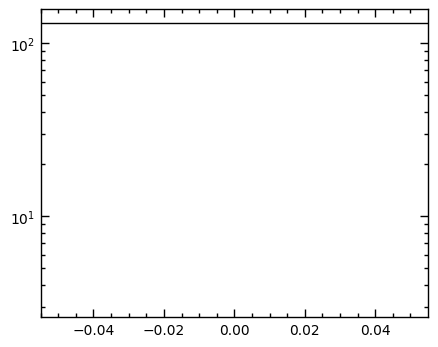

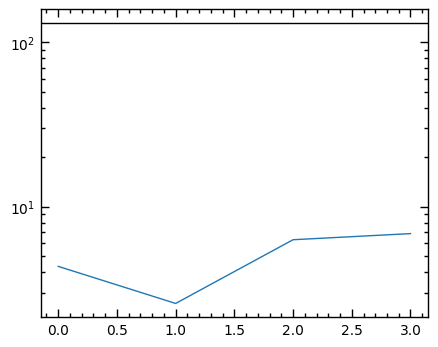

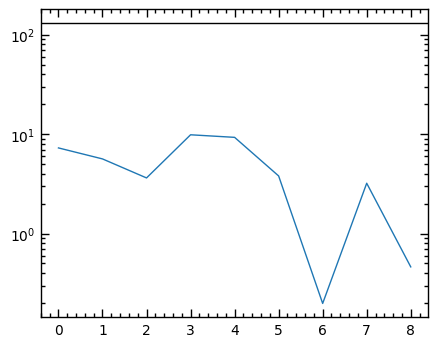

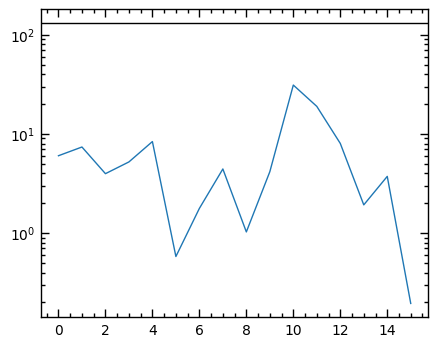

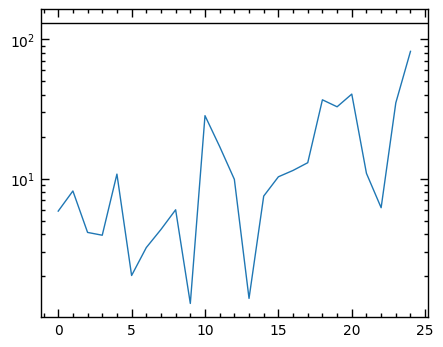

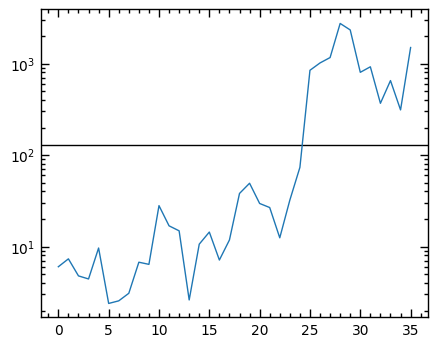

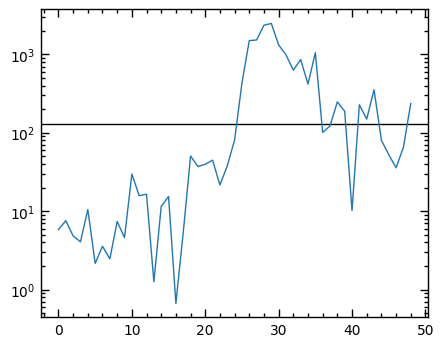

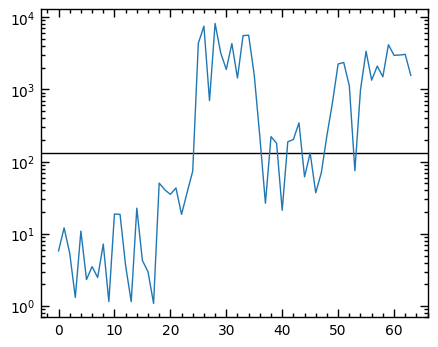

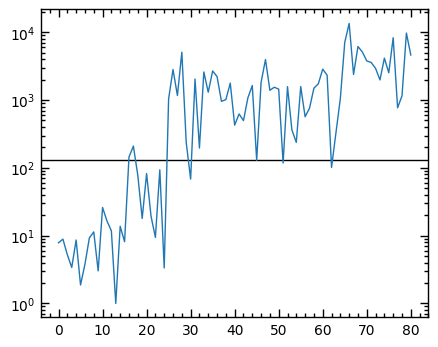

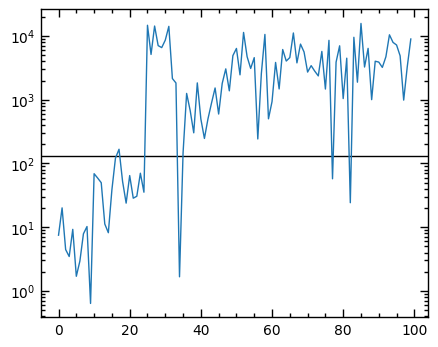

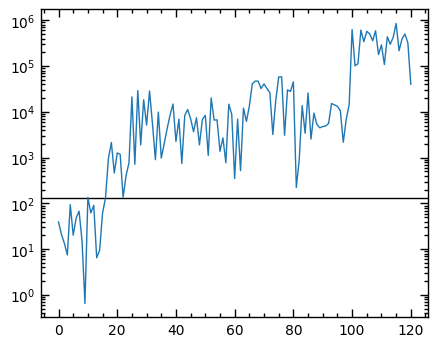

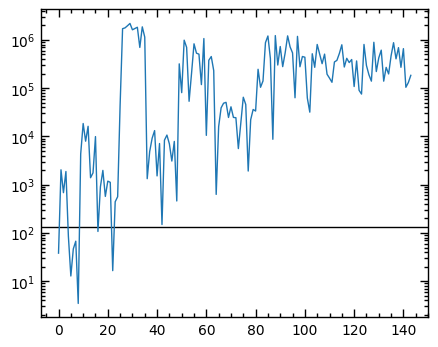

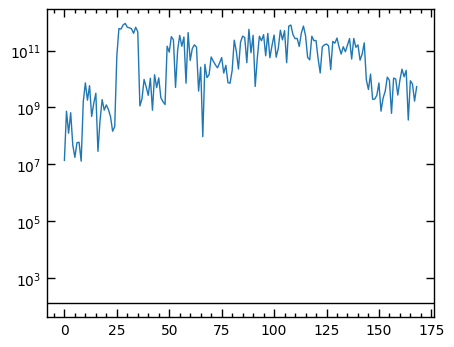

(0.0, 45.0)

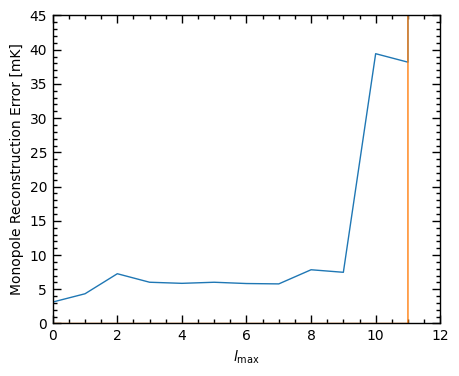

In [9]:
# Generate single-frequency noisy foregrounds.
fg = SM.foreground_gsma_alm_nsidelo(nu=50, lmax=32, nside=32, use_mat_Y=True)

# Truncate this at various ell values.
ell_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12]
N_arr   = [RS.get_size(ell) for ell in ell_arr]
fg_truncs = [fg[:N] for N in N_arr]

# Generate observation matrix for 7 antennas.
times = np.linspace(0, 24, 24, endpoint=False)
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside=32, lmax=32, 
                                                  lats=np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3]), 
                                                  times=times, beam_use=narrow_cosbeam, return_mat=True)

# Observe for various ell values
mat_A_truncs = [mat_A[:,:N] for N in N_arr]#[mat_P@mat_Y_i@mat_B_i for mat_Y_i,mat_B_i in zip(mat_Y_truncs, mat_B_truncs)]
d_truncs = [mat_A_i@fg_i for mat_A_i,fg_i in zip(mat_A_truncs,fg_truncs)]

# Add noise.
d_noise_andcov_truncs = [SM.add_noise(d, dnu=1, Ntau=len(times), t_int=200, seed=456) for d in d_truncs]
d_noise_truncs, d_cov_truncs = map(list, zip(*d_noise_andcov_truncs))

# Compute the maxlike estimator matrix for each case.
mat_W_truncs = [MM.calc_ml_estimator_matrix(mat_A_i, mat_N_i, cond=True) for mat_A_i, mat_N_i in zip(mat_A_truncs, d_cov_truncs)]

# Reconstruct the alm for each truncation case.
alm_rec_truncs = [mat_W_i @ d_noise_i for mat_W_i,d_noise_i in zip(mat_W_truncs,d_noise_truncs)]
alm_rec_truncs_nonoise = [mat_W_i @ d_i for mat_W_i,d_i in zip(mat_W_truncs,d_truncs)]

# Visualise the reconstruction error for each case.
for fg_i,alm_rec_i in zip(fg_truncs,alm_rec_truncs):
    plt.axhline(y=130, color='k')
    plt.semilogy(1e3*np.abs((alm_rec_i-fg_i)*alm2temp))
    plt.show()

# Visualise the reconstruction error for the monopole in each case.
mon_err = [1e3*np.abs((alm_rec_i[0]-fg_i[0])*alm2temp) for fg_i,alm_rec_i in zip(fg_truncs,alm_rec_truncs)]
mon_err_nonoise = [1e3*np.abs((alm_rec_i[0]-fg_i[0])*alm2temp) for fg_i,alm_rec_i in zip(fg_truncs,alm_rec_truncs_nonoise)]
plt.plot(ell_arr,mon_err)
plt.plot(ell_arr,mon_err_nonoise)
plt.xlabel(r"$l_\mathrm{max}$")
plt.ylabel(r"Monopole Reconstruction Error [mK]")
plt.xlim(0,12)
plt.ylim(0, 45)

In [12]:
mon_err_nonoise

[4.105019496257273e-09,
 2.0525097481286365e-09,
 5.131274370321591e-09,
 2.0525097481286365e-09,
 1.0262548740643183e-09,
 1.0262548740643183e-09,
 4.105019496257273e-09,
 4.105019496257273e-09,
 6.875907656230933e-08,
 1.231505848877182e-08,
 3.0377144272303825e-07,
 0.0002459789257449802,
 13857499.184344418]

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
1/condition #: 1.0
1/condition #: 0.3440022683862575
1/condition #: 0.12421586465957934
1/condition #: 0.03677330645651449
1/condition #: 0.0042555659502995285
1/condition #: 3.228096848087221e-06
1/condition #: 2.7453449992825495e-06
1/condition #: 7.744476632168276e-08
1/condition #: 5.2042919322295867e-08
1/condition #: 7.334367686386215e-09
1/condition #: 6.660818436521841e-12
1/condition #: 3.704435264372286e-13
1/condition #: 3.8209761197479085e-24


Text(0, 0.5, 'Monopole Reconstruction Error [mK]')

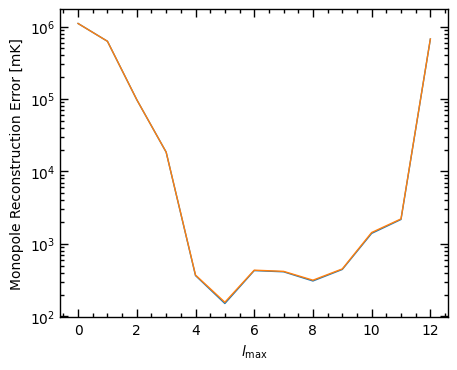

In [10]:
# Generate single-frequency noisy foregrounds.
fg = SM.foreground_gsma_alm_nsidelo(nu=50, lmax=32, nside=32, use_mat_Y=True)

# Truncate this at various ell values.
ell_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12]
N_arr   = [RS.get_size(ell) for ell in ell_arr]

# Generate observation matrix for 7 antennas.
times = np.linspace(0, 24, 24, endpoint=False)
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside=32, lmax=32, 
                                                  lats=np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3]), 
                                                  times=times, beam_use=narrow_cosbeam, return_mat=True)

# Observe for various ell values
mat_A_truncs = [mat_A[:,:N] for N in N_arr]
d = mat_A@fg

# Add noise.
d_noise, d_cov = SM.add_noise(d, dnu=1, Ntau=len(times), t_int=200, seed=456)

# Compute the maxlike estimator matrix for each lmod.
mat_W_truncs = [MM.calc_ml_estimator_matrix(mat_A_i, d_cov, cond=True) for mat_A_i in mat_A_truncs]

# Reconstruct the alm for each truncation case.
alm_rec_truncs = [mat_W_i @ d_noise for mat_W_i in mat_W_truncs]
alm_rec_truncs_nonoise = [mat_W_i @ d for mat_W_i in mat_W_truncs]

# Visualise the reconstruction error for the monopole in each case.
mon_err = [1e3*np.abs((alm_rec_i[0]-fg[0])*alm2temp) for alm_rec_i in alm_rec_truncs]
mon_err_nonoise = [1e3*np.abs((alm_rec_i[0]-fg[0])*alm2temp) for alm_rec_i in alm_rec_truncs_nonoise]
plt.semilogy(ell_arr,mon_err)
plt.xlabel(r"$l_\mathrm{max}$")
plt.ylabel(r"Monopole Reconstruction Error [mK]")

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
1/condition #: 1.0
1/condition #: 0.36414251941012865
1/condition #: 0.14731059753236322
1/condition #: 0.029779908382230224
1/condition #: 0.0017894663084600173
1/condition #: 1.3653823326972614e-08
1/condition #: 1.1901103454084829e-08
1/condition #: 2.311873763675074e-09
1/condition #: 1.901001431575031e-09
1/condition #: 9.893854479997252e-12
1/condition #: 2.014729841501186e-24
1/condition #: 7.840872116890842e-24
1/condition #: 8.4239105424018e-25


Text(0, 0.5, 'Monopole Reconstruction Error [mK]')

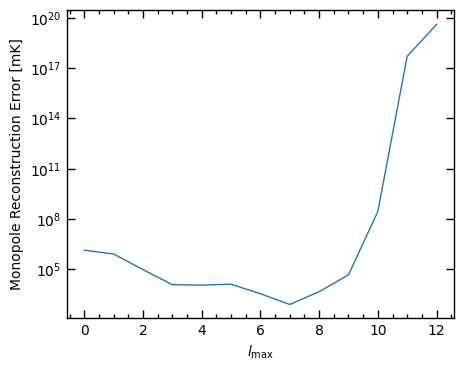

In [13]:
# Generate single-frequency noisy foregrounds.
fg = SM.foreground_gsma_alm_nsidelo(nu=50, lmax=32, nside=32, use_mat_Y=True)

# Truncate this at various ell values.
ell_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12]
N_arr   = [RS.get_size(ell) for ell in ell_arr]

# Generate observation matrix for 5 antennas.
times = np.linspace(0, 24, 24, endpoint=False)
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside=32, lmax=32, 
                                                  lats=np.array([-26*2, -26, 0, 26, 26*2]), 
                                                  times=times, beam_use=narrow_cosbeam, return_mat=True)

# Observe for various ell values
mat_A_truncs = [mat_A[:,:N] for N in N_arr]
d = mat_A@fg

# Add noise.
d_noise, d_cov = SM.add_noise(d, dnu=1, Ntau=len(times), t_int=200, seed=456)

# Compute the maxlike estimator matrix for each lmod.
mat_W_truncs = [MM.calc_ml_estimator_matrix(mat_A_i, d_cov, cond=True) for mat_A_i in mat_A_truncs]

# Reconstruct the alm for each truncation case.
alm_rec_truncs = [mat_W_i @ d_noise for mat_W_i in mat_W_truncs]
alm_rec_truncs_nonoise = [mat_W_i @ d for mat_W_i in mat_W_truncs]

# Visualise the reconstruction error for the monopole in each case.
mon_err = [1e3*np.abs((alm_rec_i[0]-fg[0])*alm2temp) for alm_rec_i in alm_rec_truncs]
mon_err_nonoise = [1e3*np.abs((alm_rec_i[0]-fg[0])*alm2temp) for alm_rec_i in alm_rec_truncs_nonoise]
plt.semilogy(ell_arr,mon_err)
plt.xlabel(r"$l_\mathrm{max}$")
plt.ylabel(r"Monopole Reconstruction Error [mK]")

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
1/condition #: 1.0
1/condition #: 0.1928427935578817
1/condition #: 0.017874694778719696
1/condition #: 1.6124540153727177e-05
1/condition #: 1.1564738841749258e-06
1/condition #: 5.638304124159811e-11
1/condition #: 9.91193177111973e-12
1/condition #: 2.573147333037498e-19
1/condition #: 2.2638623017421316e-22
1/condition #: 4.743666035155051e-22
1/condition #: 5.221329632178677e-25
1/condition #: 2.4279613383851087e-24
1/condition #: 2.7947438357572413e-25


Text(0, 0.5, 'Monopole Reconstruction Error [mK]')

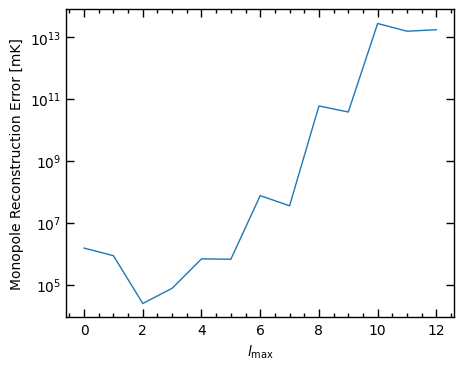

In [14]:
# Generate single-frequency noisy foregrounds.
fg = SM.foreground_gsma_alm_nsidelo(nu=50, lmax=32, nside=32, use_mat_Y=True)

# Truncate this at various ell values.
ell_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12]
N_arr   = [RS.get_size(ell) for ell in ell_arr]

# Generate observation matrix for 5 antennas.
times = np.linspace(0, 24, 24, endpoint=False)
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan(nside=32, lmax=32, 
                                                  lats=np.array([-26, 0, 26]), 
                                                  times=times, beam_use=narrow_cosbeam, return_mat=True)

# Observe for various ell values
mat_A_truncs = [mat_A[:,:N] for N in N_arr]
d = mat_A@fg

# Add noise.
d_noise, d_cov = SM.add_noise(d, dnu=1, Ntau=len(times), t_int=200, seed=456)

# Compute the maxlike estimator matrix for each lmod.
mat_W_truncs = [MM.calc_ml_estimator_matrix(mat_A_i, d_cov, cond=True) for mat_A_i in mat_A_truncs]

# Reconstruct the alm for each truncation case.
alm_rec_truncs = [mat_W_i @ d_noise for mat_W_i in mat_W_truncs]
alm_rec_truncs_nonoise = [mat_W_i @ d for mat_W_i in mat_W_truncs]

# Visualise the reconstruction error for the monopole in each case.
mon_err = [1e3*np.abs((alm_rec_i[0]-fg[0])*alm2temp) for alm_rec_i in alm_rec_truncs]
mon_err_nonoise = [1e3*np.abs((alm_rec_i[0]-fg[0])*alm2temp) for alm_rec_i in alm_rec_truncs_nonoise]
plt.semilogy(ell_arr,mon_err)
plt.xlabel(r"$l_\mathrm{max}$")
plt.ylabel(r"Monopole Reconstruction Error [mK]")